# Create dataloader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class ClassificationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_dir = os.path.join(root_dir, "images")
        self.label_dir = os.path.join(root_dir, "labels")
        self.image_files = [f for f in os.listdir(self.image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Lấy đường dẫn file ảnh và label
        image_name = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_name)
        label_path = os.path.join(self.label_dir, os.path.splitext(image_name)[0] + '.txt')

        # Đọc ảnh
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Đọc label (chỉ lấy class của dòng đầu tiên)
        with open(label_path, 'r') as f:
            first_line = f.readline().strip()
            class_id = int(first_line.split()[0])  # lấy class ở đầu dòng

        return image, torch.tensor(class_id, dtype=torch.long)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Tạo dataset và dataloader
trainset = ClassificationDataset(root_dir='/content/drive/MyDrive/ImageGuard/dataset/train', transform=transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)

testset = ClassificationDataset(root_dir='/content/drive/MyDrive/ImageGuard/dataset/test', transform=transform)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

#ResNet 34

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
class BuildingBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
    super(BuildingBlock, self).__init__()

    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(inplace=True)

    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels)

    self.shortcut = nn.Identity()
    if stride != 1 or in_channels != out_channels:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0, bias=False),
          nn.BatchNorm2d(out_channels)
      )

  def forward(self, x):
    identity = self.shortcut(x)
    x = self.conv1(x) #W1 * x
    x = self.bn1(x)
    x = self.relu(x) #sigma(W1 * x)

    x = self.conv2(x) #W2 * sigma(W1 * x) = F(x)
    x = self.bn2(x)
    x += identity # F(x) + x
    x = self.relu(x) #sigma(F(x) + x)
    return x

In [ ]:
class ResNet34(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(ResNet34, self).__init__()

    self.conv = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
    self.bn = nn.BatchNorm2d(64)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.layer1 = self._make_layer(64, 64, num_blocks=3)
    self.layer2 = self._make_layer(64, 128, num_blocks=4, stride=2)
    self.layer3 = self._make_layer(128, 256, num_blocks=6, stride=2)
    self.layer4 = self._make_layer(256, 512, num_blocks=3, stride=2)

    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(512, out_channels)

  def _make_layer(self, in_channels, out_channels, num_blocks, stride=1):
    layers = []
    layers.append(BuildingBlock(in_channels, out_channels, stride=stride))
    for _ in range(1, num_blocks):
      layers.append(BuildingBlock(out_channels, out_channels, stride=1))
    return nn.Sequential(*layers)

  def forward(self, x):
    x = self.conv(x)
    x = self.bn(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x= self.avgpool(x)
    x = torch.flatten(x, 1)
    output = self.fc(x)
    return output

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet34(in_channels=3, out_channels=3).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 60, 90], gamma=0.1)

Epoch [1/100], Loss: 4.4100, LR: 0.100000
Epoch [2/100], Loss: 1.0459, LR: 0.100000
Epoch [3/100], Loss: 0.9719, LR: 0.100000
Epoch [4/100], Loss: 0.9697, LR: 0.100000
Epoch [5/100], Loss: 0.9573, LR: 0.100000
Epoch [6/100], Loss: 0.9761, LR: 0.100000
Epoch [7/100], Loss: 0.9903, LR: 0.100000
Epoch [8/100], Loss: 0.9125, LR: 0.100000
Epoch [9/100], Loss: 0.8897, LR: 0.100000
Epoch [10/100], Loss: 0.8225, LR: 0.100000
Epoch [11/100], Loss: 0.8477, LR: 0.100000
Epoch [12/100], Loss: 0.8259, LR: 0.100000
Epoch [13/100], Loss: 0.7674, LR: 0.100000
Epoch [14/100], Loss: 0.7283, LR: 0.100000
Epoch [15/100], Loss: 0.7468, LR: 0.100000
Epoch [16/100], Loss: 0.7416, LR: 0.100000
Epoch [17/100], Loss: 0.7122, LR: 0.100000
Epoch [18/100], Loss: 0.7116, LR: 0.100000
Epoch [19/100], Loss: 0.6830, LR: 0.100000
Epoch [20/100], Loss: 0.6807, LR: 0.100000
Epoch [21/100], Loss: 0.6537, LR: 0.100000
Epoch [22/100], Loss: 0.6454, LR: 0.100000
Epoch [23/100], Loss: 0.6813, LR: 0.100000
Epoch [24/100], Loss

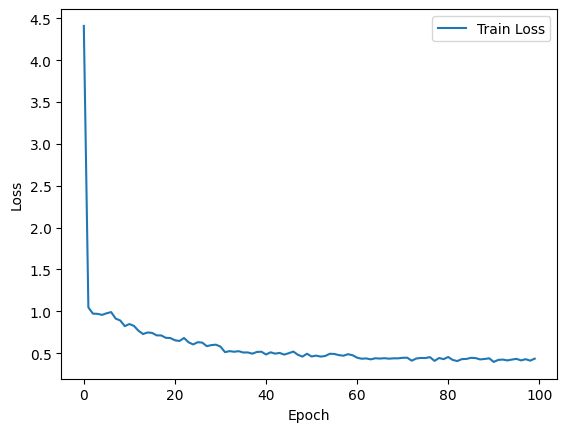

In [ ]:
num_epochs = 100
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, original_labels in trainloader:
        images = images.to(device)
        original_labels = original_labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, original_labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)
    train_losses.append(avg_loss)

    scheduler.step()

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, LR: {current_lr:.6f}")

plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, original_labels in testloader:
        images = images.to(device)
        original_labels = original_labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += original_labels.size(0)
        correct += (predicted == original_labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on test set: {accuracy:.2f}%")

Accuracy on test set: 80.74%


In [ ]:
image, label = testset[0]
image = image.unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model(image)
    _, predicted = torch.max(output, 1)

In [ ]:
torch.save(model.state_dict(), "resnet34.pth")

# Vision Transformer

In [ ]:
class PatchEmbedding(nn.Module):
  def __init__(self, img_size=224, in_channels=3, patch_size=16, hidden_dim=768):
    super(PatchEmbedding, self).__init__()
    """
    H, W: 224
    C: 3
    P: 16
    D: 768
    """
    self.img_size = img_size
    self.in_channels = in_channels
    self.patch_size = patch_size
    self.hidden_dim = hidden_dim
    #Number of patches
    self.num_patches = (self.img_size * self.img_size) // (self.patch_size * self.patch_size)

    #x_class
    self.class_embedding = nn.Parameter(torch.randn(1, 1, self.hidden_dim)) #(1, 1, D)

    #Linear projection (E)
    self.projection = nn.Linear(self.patch_size * self.patch_size * self.in_channels, self.hidden_dim) #(P^2 * C, D)

    #Pos_embedding (E_pos)
    self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, self.hidden_dim)) #(1, N+1, D)

  def forward(self, x):
    #Chia ảnh thành các patches
    B, C, H, W = x.shape
    x = x.unfold(2, self.patch_size, self.patch_size) #(B, C, Num_patches_H, P, W)
    x = x.unfold(3, self.patch_size, self.patch_size) #(B, C, Num_patches_H, Num_patches_W, P, P)
    x = x.permute(0, 2, 3, 1, 4, 5).contiguous() #(B, Num_patches_H, Num_patches_W, C, P, P)
    x = x.view(B, self.num_patches, -1) #(B, N, P*2 \times C)

    #Ánh xạ vào không gian embedding
    x = self.projection(x) #(B, N, D)

    #Expand để class token có cùng chiều với projection
    class_token = self.class_embedding.expand(B, -1, -1) #(B, 1, D)

    #Ghép class token vào đầu chuỗi patches
    x = torch.cat([class_token, x], dim=1) #(B, N+1, D)

    #Cộng với E_pos -> z_0
    x = x + self.pos_embedding #(B, N+1, D)

    return x #encoded_value

In [ ]:
class MultiHeadSelfAttention(nn.Module):
  def __init__(self, hidden_dim=768, heads=12):
    super(MultiHeadSelfAttention, self).__init__()
    self.hidden_dim = hidden_dim
    self.heads = heads
    self.head_dim = hidden_dim // heads

    #Khởi tạo trọng số cho query, key, value
    self.W_Q = nn.Linear(self.hidden_dim, self.hidden_dim)
    self.W_K = nn.Linear(self.hidden_dim, self.hidden_dim)
    self.W_V = nn.Linear(self.hidden_dim, self.hidden_dim)

    self.softmax = nn.Softmax(dim=-1)
    self.output = nn.Linear(self.hidden_dim, self.hidden_dim) #Kết hợp đầu ra của các heads

  def forward(self, x):
    #x: encoded_value có kích thước là (B, N+1, D)
    B, N, D = x.shape #Batch_size, Số tokens, hidden_dim #(B, N+1, D theo N ban đầu)

    #Tính query, key, value
    q = self.W_Q(x).view(B, N, self.heads, self.head_dim).transpose(1, 2)
    k = self.W_K(x).view(B, N, self.heads, self.head_dim).transpose(1, 2)
    v = self.W_V(x).view(B, N, self.heads, self.head_dim).transpose(1, 2)

    #Tính attention score
    unscaled_dot_product_similarities = torch.matmul(q, k.transpose(-1, -2)) #QK^T
    scaled_dot_product_similarities = unscaled_dot_product_similarities / (self.head_dim ** 0.5) #QK^T / sqrt(d_k)
    attention_weights = self.softmax(scaled_dot_product_similarities) #softmax(QK^T / sqrt(d_k))
    attention_score = torch.matmul(attention_weights, v) #softmax(QK^T / sqrt(d_k))V

    #Gộp các đầu SA lại với nhau
    output = attention_score.transpose(1, 2).contiguous().view(B, N, D)

    #Ánh xạ lại không gian embedding
    output = self.output(output)

    return output

In [ ]:
class TransformerEncoder(nn.Module):
  def __init__(self, img_size=224, layers=12, patch_size=16, in_channels=3, hidden_dim=768, heads=12, mlp_size=3072):
    super(TransformerEncoder, self).__init__()
    self.hidden_dim = hidden_dim #D=768
    self.in_channels = in_channels #C=3
    self.heads = heads
    self.layers = layers
    self.mlp_size = mlp_size
    self.img_size = img_size
    self.patch_size = patch_size
    self.embedded_patches = PatchEmbedding(img_size=self.img_size, patch_size=self.patch_size, in_channels=self.in_channels, hidden_dim=self.hidden_dim)

    #Khởi tạo khối transformer
    self.transformer_blocks = nn.ModuleList([
        nn.ModuleList([
            nn.LayerNorm(self.hidden_dim),
            MultiHeadSelfAttention(hidden_dim=self.hidden_dim, heads=self.heads),
            nn.LayerNorm(self.hidden_dim),
            nn.Sequential(
                nn.Linear(self.hidden_dim, self.mlp_size),
                nn.GELU(),
                nn.Dropout(0.1),
                nn.Linear(self.mlp_size, self.hidden_dim),
                nn.Dropout(0.1)
            )
        ]) for _ in range(self.layers)
      ])

  def forward(self, x):
    x = self.embedded_patches(x)
    for norm1, msa, norm2, mlp in self.transformer_blocks:
      x = x + msa(norm1(x))
      x = x + mlp(norm2(x))
    return x

In [ ]:
class MLPHead(nn.Module):
  def __init__(self, hidden_dim=768, num_classes=1000):
    super(MLPHead, self).__init__()
    self.hidden_dim = hidden_dim
    self.num_classes = num_classes
    self.norm = nn.LayerNorm(self.hidden_dim)
    self.fc = nn.Linear(self.hidden_dim, self.num_classes)

  def forward(self, x):
    #Lấy ra x_class từ đầu ra của encoder
    class_token = x[:, 0, :]
    class_token = self.norm(class_token)
    output = self.fc(class_token)

    return output

In [ ]:
class VisionTransformer(nn.Module):
  def __init__(self, hidden_dim=768, layers=12, heads=12, mlp_size=3072, in_channels=3, num_classes=1000, img_size=224, patch_size=16):
    super(VisionTransformer, self).__init__()
    self.encoder = TransformerEncoder(
        img_size=img_size,
        patch_size=patch_size,
        in_channels=in_channels,
        hidden_dim=hidden_dim,
        layers=layers,
        heads=heads,
        mlp_size=mlp_size
    )
    self.mlp_head = MLPHead(hidden_dim=hidden_dim, num_classes=num_classes)

  def forward(self, x):
    x = self.encoder(x)
    output = self.mlp_head(x)

    return output

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionTransformer(
    in_channels=3,
    num_classes=3
    ).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-05)

Epoch [1/100], Loss: 1.0730, LR: 0.000010
Epoch [2/100], Loss: 1.0003, LR: 0.000010
Epoch [3/100], Loss: 0.9845, LR: 0.000010
Epoch [4/100], Loss: 0.9692, LR: 0.000010
Epoch [5/100], Loss: 0.9589, LR: 0.000010
Epoch [6/100], Loss: 0.9690, LR: 0.000010
Epoch [7/100], Loss: 0.9222, LR: 0.000010
Epoch [8/100], Loss: 0.9021, LR: 0.000010
Epoch [9/100], Loss: 0.8345, LR: 0.000010
Epoch [10/100], Loss: 0.7731, LR: 0.000010
Epoch [11/100], Loss: 0.7712, LR: 0.000010
Epoch [12/100], Loss: 0.7367, LR: 0.000010
Epoch [13/100], Loss: 0.6918, LR: 0.000010
Epoch [14/100], Loss: 0.7166, LR: 0.000010
Epoch [15/100], Loss: 0.6743, LR: 0.000010
Epoch [16/100], Loss: 0.6521, LR: 0.000010
Epoch [17/100], Loss: 0.6379, LR: 0.000010
Epoch [18/100], Loss: 0.6538, LR: 0.000010
Epoch [19/100], Loss: 0.6107, LR: 0.000010
Epoch [20/100], Loss: 0.6090, LR: 0.000010
Epoch [21/100], Loss: 0.5779, LR: 0.000010
Epoch [22/100], Loss: 0.5686, LR: 0.000010
Epoch [23/100], Loss: 0.5611, LR: 0.000010
Epoch [24/100], Loss

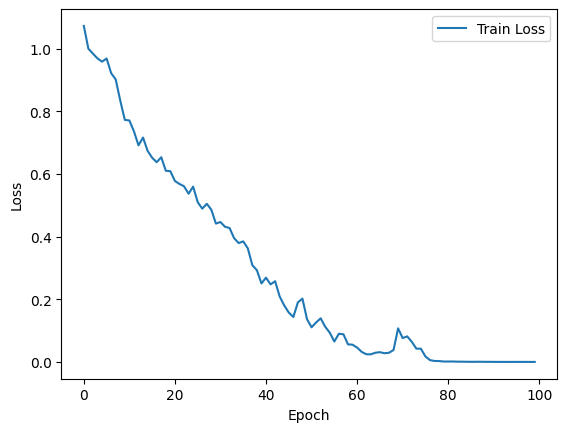

In [ ]:
num_epochs = 100
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)
    train_losses.append(avg_loss)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, LR: {current_lr:.6f}")

plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on MNIST test set: {accuracy:.2f}%")

Accuracy on MNIST test set: 74.81%


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/ImageGuard/ViT.pth")